In [1]:
import numpy as np
from numpy.random import randint
import matplotlib.pylab as plt
import sys,os
import subprocess
import tensorflow as tf
from tensorflow.keras import layers, Model

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10184297266486763850
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10398349295927879616
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 2424286068205418029
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7899945370
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9115819697176657766
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:05:00.0, compute capability: 6.1"
]


## Example of synthetic data 


In [3]:
import matplotlib as mpl


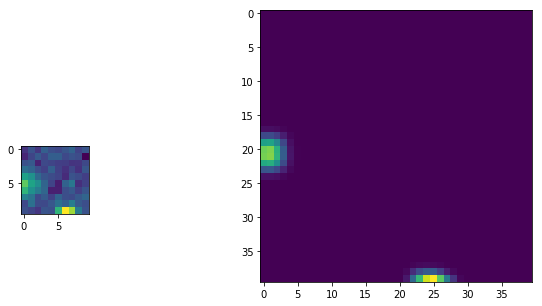

In [4]:
home = "/export/home1/users/bssn/serna"
datadir = "/mnt/data/synthetic/syndat/"
#os.listdir(datadir)
i = randint(0,900)
F = np.load(datadir+"dvids.npy")
O4 = np.load(datadir+"o4s.npy")
Ft = F[:,:,:,i]
Ot4 = O4[:,:,i]
fig = plt.figure(figsize=(14,5))
gs = mpl.gridspec.GridSpec(4, 8 , wspace=0., hspace=0.) # 2x3 grid
ax0 = fig.add_subplot(gs[2:3,2:3]) # first full col
ax1 = fig.add_subplot(gs[:,4:]) # first row, second col

ax0.imshow(Ft.mean(axis=-1))
ax1.imshow(Ot4)
width,height,T = Ft.shape  

# Obtaining training data set

In [5]:
def get_random_time_segment(segment_frames,total_frames=12000):
    '''
    Gets a random time segment of duration segment_frames in a file
    with number of frames: total_frames
    '''
    
    segment_start = randint(0, high = total_frames-
                                   segment_frames)
    segment_end = segment_start + segment_frames
    
    return (segment_start, segment_end)

def readdata(nframes,i0=0,n=800,magn=2,repeat = 4, idx = None):
    if idx is None:
        F = np.load(datadir+"dvids.npy")
        O4 = np.load(datadir+"o4s.npy")
    else:
        F = np.load(datadir+"dvids"+str(idx)+".npy")
        O4 = np.load(datadir+"o4s"+str(idx)+".npy")
        
    X = np.zeros((n*repeat,width,height,nframes))
    Y = np.zeros((n*repeat,width*magn,height*magn))
    j = 0
    sel = np.arange(i0,i0+n)
    np.random.shuffle(sel)
    for i in sel:
        xt = F[:,:,:,i]
        yt = O4[:,:,i] 
        xt = xt/xt.max()
        ymax = max(1,yt.max())
        # This is to avoid 0s in pictures without blinking spots, 
        # but it may give us problems, most likely
        for ir in range(repeat):
            start,end = get_random_time_segment(nframes,T)
            X[j,:,:,:] = xt[:,:,start:end]
            Y[j,:,:] = yt/ymax
            j = j+1
    X = np.reshape(X,(X.shape[0],X.shape[1],X.shape[2],X.shape[3],1))
    #Y = reshape(Y,(Y.shape[0],Y.shape[1],Y.shape[2],1,1))
    return(X,Y)

In [6]:
nframes = 300
X,Y = readdata(nframes,n=800,magn=4,repeat = 4)
print('X,Y training data shapes:',X.shape,Y.shape)

Xdev,Ydev = readdata(nframes,i0=800,n=100,magn=4,repeat =1)
print('X,Y validation data shapes:',Xdev.shape,Ydev.shape)


X,Y training data shapes: (3200, 10, 10, 300, 1) (3200, 40, 40)
X,Y validation data shapes: (100, 10, 10, 300, 1) (100, 40, 40)


## Model definition

In [7]:
import tensorflow.keras.backend as K


In [8]:


#Mendel ...? Loss function
def MOC(y_true,y_pred):
    '''Just another crossentropy'''
    ly = K.sum(y_true*y_pred)
    ly2 = K.sum(y_pred*y_pred)
    ly3 = K.sum(y_true*y_true)
    out = ly/K.sqrt(ly2*ly3)
    return out
def MOCl(y_true,y_pred):
    '''Just another crossentropy'''
    ly = K.sum(y_true*y_pred)
    ly2 = K.sum(y_pred*y_pred)
    ly3 = K.sum(y_true*y_true)
    out = ly/K.sqrt(ly2*ly3)
    return 1-out

def PCCl(y_true,y_pred):
    '''Just another crossentropy'''
    lt1 = y_true-K.mean(y_true)
    lt2 = y_pred-K.mean(y_pred)
    
    ly = K.sum(lt1*lt2)
    ly2 = K.sum(lt1*lt1)
    ly3 = K.sum(lt2*lt2)
    out = ly/K.sqrt(ly2*ly3)
    
    return 1.0-out

def PCC(y_true,y_pred):
    '''Just another crossentropy'''
    lt1 = y_true-K.mean(y_true)
    lt2 = y_pred-K.mean(y_pred)
    
    ly = K.sum(lt1*lt2)
    ly2 = K.sum(lt1*lt1)
    ly3 = K.sum(lt2*lt2)
    out = ly/K.sqrt(ly2*ly3)
    
    return 1.0-out


In [9]:
model = tf.keras.models.Sequential([
tf.keras.layers.Conv3D(16, (3,3,5),padding='same', activation = 'relu', input_shape = (width,height,nframes,1)),
tf.keras.layers.MaxPooling3D(pool_size=(1,1,4)),
tf.keras.layers.Dropout(0.1),
tf.keras.layers.Conv3D(32, (3,3,5),padding='same', activation = 'relu'),
tf.keras.layers.MaxPooling3D(pool_size=(2,2,4)),
tf.keras.layers.Dropout(0.1),
tf.keras.layers.Conv3D(128, (3,3,5),padding='same', activation = 'relu'),
tf.keras.layers.MaxPooling3D(pool_size=(2,2,4)),
tf.keras.layers.Flatten(),
tf.keras.layers.Dropout(0.1),
tf.keras.layers.Dense(256, activation = 'relu'),
tf.keras.layers.Dropout(0.1),
tf.keras.layers.Dense(40*40, activation = 'relu'),
tf.keras.layers.Reshape((40,40)),
])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 10, 10, 300, 16)   736       
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 10, 75, 16)    0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 10, 75, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 10, 75, 32)    23072     
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 5, 5, 18, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 18, 32)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 5, 18, 128)     184448    
__________

In [11]:
from tensorflow.keras.optimizers import Adam,RMSprop,SGD

In [12]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        moc, mocv = logs.get('MOC'), logs.get('MOC_val')
        if(np.abs(float(moc)-float(mocv))>2*float(mocv)):
            print("\nSeparating behaviour!")
            self.model.stop_training = True


In [13]:
#datadir = home+"/SyntheticData/syndat/"
datadir = "/mnt/data/synthetic/syndat/"
X,Y = readdata(nframes,n=800,magn=4,repeat = 4)

In [14]:
model.compile(optimizer = Adam(lr = 0.005), 
              loss = MOCl, 
              metrics =[PCC])

In [15]:
callbacks = myCallback()
ytr = np.abs(0.02*np.random.randn(Y.shape[0],Y.shape[1],Y.shape[2]))
Y1 = Y +ytr
history = model.fit(X,Y1, batch_size = 100, epochs = 50,
                           validation_data = (Xdev,Ydev),verbose=1)

Train on 3200 samples, validate on 100 samples
Epoch 1/50
3200/3200 [==============================] - 11s 3ms/step - loss: 0.6932 - PCC: 0.9913 - val_loss: 0.7805 - val_PCC: 0.9992
Epoch 2/50
3200/3200 [==============================] - 3s 1ms/step - loss: 0.6781 - PCC: 0.9880 - val_loss: 0.7790 - val_PCC: 0.9962
Epoch 3/50
3200/3200 [==============================] - 3s 1ms/step - loss: 0.6752 - PCC: 0.9746 - val_loss: 0.7728 - val_PCC: 0.9659
Epoch 4/50
3200/3200 [==============================] - 3s 1ms/step - loss: 0.6690 - PCC: 0.9420 - val_loss: 0.7627 - val_PCC: 0.9299
Epoch 5/50
3200/3200 [==============================] - 3s 1ms/step - loss: 0.6441 - PCC: 0.8612 - val_loss: 0.7115 - val_PCC: 0.8204
Epoch 6/50
3200/3200 [==============================] - 3s 1ms/step - loss: 0.6010 - PCC: 0.7648 - val_loss: 0.6635 - val_PCC: 0.7470
Epoch 7/50
3200/3200 [==============================] - 4s 1ms/step - loss: 0.5606 - PCC: 0.6929 - val_loss: 0.6320 - val_PCC: 0.7045
Epoch 8/50
320

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'],'C0',alpha=0.7)
plt.plot(history.history['val_loss'],'C0')
plt.plot(history.history['PCC'],'C1',alpha=0.7)
plt.plot(history.history['val_PCC'],'C1')

In [16]:
datadir = "/mnt/data/synthetic/syndat/"

In [17]:
X,Y = readdata(nframes,n=900,magn=4,repeat = 4,idx=0)
historys = {}

In [18]:
for k in range(5):
    for i in range(10):
        ytr = np.abs(0.05*np.random.randn(Y.shape[0],Y.shape[1],Y.shape[2]))
        Y1 = Y +ytr
        #prGen = subprocess.Popen('./generatemore.sh')
        historys[i+k*10] = model.fit(X,Y1, batch_size = 100, epochs = 10,
                               validation_data = (Xdev,Ydev),verbose=1)
        #model.save("/mnt/data/synthetic/deepsofi_v2_1_t_"+str(i//10).zfill(4)+".h5")
        print(i)
        #prGen.wait()
        X,Y = readdata(nframes,n=900,magn=4,repeat = 4,idx= (i+1)%10)
    model.save_weights("/mnt/data/synthetic/deepsofi_v2_1_t_"+str(k)+".h5")


Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 4s 1ms/step - loss: 0.4749 - PCC: 0.6091 - val_loss: 0.5353 - val_PCC: 0.5797
Epoch 2/10
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3942 - PCC: 0.5375 - val_loss: 0.5085 - val_PCC: 0.5500
Epoch 3/10
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3710 - PCC: 0.4974 - val_loss: 0.4963 - val_PCC: 0.5369
Epoch 4/10
3600/3600 [==============================] - 4s 995us/step - loss: 0.3516 - PCC: 0.4613 - val_loss: 0.4892 - val_PCC: 0.5303
Epoch 5/10
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3366 - PCC: 0.4325 - val_loss: 0.4853 - val_PCC: 0.5268
Epoch 6/10
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3207 - PCC: 0.4030 - val_loss: 0.4882 - val_PCC: 0.5300
Epoch 7/10
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3098 - PCC: 0.3830 - val_loss: 0.4957 - val_PCC: 0.5379
Epoch 8/10
36

3600/3600 [==============================] - 4s 1ms/step - loss: 0.2561 - PCC: 0.2959 - val_loss: 0.4157 - val_PCC: 0.4469
Epoch 10/10
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2488 - PCC: 0.2840 - val_loss: 0.4248 - val_PCC: 0.4566
5
Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 4s 997us/step - loss: 0.3897 - PCC: 0.4876 - val_loss: 0.4119 - val_PCC: 0.4418
Epoch 2/10
3600/3600 [==============================] - 4s 995us/step - loss: 0.3414 - PCC: 0.4320 - val_loss: 0.4045 - val_PCC: 0.4343
Epoch 3/10
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3175 - PCC: 0.3954 - val_loss: 0.4014 - val_PCC: 0.4315
Epoch 4/10
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3037 - PCC: 0.3731 - val_loss: 0.3987 - val_PCC: 0.4289
Epoch 5/10
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2913 - PCC: 0.3533 - val_loss: 0.3947 - val_PCC: 0.4245
Epoch 6/10
3600/360

3600/3600 [==============================] - 4s 996us/step - loss: 0.2557 - PCC: 0.2888 - val_loss: 0.3808 - val_PCC: 0.4080
Epoch 8/10
3600/3600 [==============================] - 4s 995us/step - loss: 0.2459 - PCC: 0.2744 - val_loss: 0.3816 - val_PCC: 0.4085
Epoch 9/10
3600/3600 [==============================] - 4s 995us/step - loss: 0.2404 - PCC: 0.2656 - val_loss: 0.3855 - val_PCC: 0.4129
Epoch 10/10
3600/3600 [==============================] - 4s 996us/step - loss: 0.2361 - PCC: 0.2587 - val_loss: 0.3862 - val_PCC: 0.4130
1
Train on 3600 samples, validate on 100 samples
Epoch 1/10
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3672 - PCC: 0.4395 - val_loss: 0.3761 - val_PCC: 0.4038
Epoch 2/10
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3226 - PCC: 0.3905 - val_loss: 0.3621 - val_PCC: 0.3884
Epoch 3/10
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3037 - PCC: 0.3642 - val_loss: 0.3634 - val_PCC: 0.3900
Epoch 4/10
3600

KeyboardInterrupt: 

In [19]:
model.save_weights("/mnt/data/synthetic/deepsofi_v2_1_t_"+str(k)+".h5")


In [20]:
historys.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])

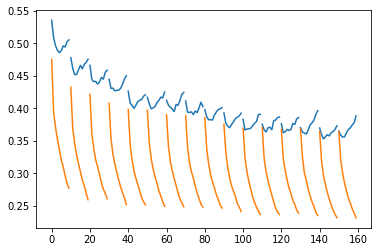

In [23]:
try:
    i0 = len(history.history['val_loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
except:
    i0 = 0
for i in range(len(historys.keys())):
    vMOC = historys[i].history['val_loss']
    t = np.arange(len(vMOC))+i0
    plt.plot(t,vMOC,'C0')
    plt.plot(t,historys[i].history['loss'],'C1')
    
    i0 = t[-1]+1

In [50]:
i0 = i+1
prGen = subprocess.Popen('./generatemore.sh')
prGen.wait()

0

In [51]:
X,Y = readdata(nframes,n=900,magn=4,repeat = 4)

In [52]:
for i in range(150):
    ytr = np.abs(0.05*np.random.randn(Y.shape[0],Y.shape[1],Y.shape[2]))
    Y1 = Y +ytr
    prGen = subprocess.Popen('./generatemore.sh')
    historys[i+i0] = model.fit(X,Y1, batch_size = 100, epochs = 5,
                           validation_data = (Xdev,Ydev),verbose=1)
    #model.save("/mnt/data/synthetic/deepsofi_v2_1_t_"+str(i//10).zfill(4)+".h5")
    print(i)
    prGen.wait()
    X,Y = readdata(nframes,n=900,magn=4,repeat = 4)
    if i%10==0:
        model.save_weights("/mnt/data/synthetic/deepsofi_v2_1_t_"+str(i).zfill(3)+".h5")


Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3398 - PCC: 0.4087 - val_loss: 0.3377 - val_PCC: 0.3609
Epoch 2/5
3600/3600 [==============================] - 4s 989us/step - loss: 0.3110 - PCC: 0.3732 - val_loss: 0.3233 - val_PCC: 0.3457
Epoch 3/5
3600/3600 [==============================] - 4s 991us/step - loss: 0.2968 - PCC: 0.3524 - val_loss: 0.3273 - val_PCC: 0.3501
Epoch 4/5
3600/3600 [==============================] - 4s 992us/step - loss: 0.2829 - PCC: 0.3319 - val_loss: 0.3218 - val_PCC: 0.3443
Epoch 5/5
3600/3600 [==============================] - 4s 992us/step - loss: 0.2720 - PCC: 0.3153 - val_loss: 0.3244 - val_PCC: 0.3472
0
Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3396 - PCC: 0.4097 - val_loss: 0.3374 - val_PCC: 0.3604
Epoch 2/5
3600/3600 [==============================] - 4s 993us/step - loss: 0.3118 - PCC: 0.3753 

3600/3600 [==============================] - 4s 1ms/step - loss: 0.2909 - PCC: 0.3423 - val_loss: 0.3196 - val_PCC: 0.3420
Epoch 4/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2797 - PCC: 0.3252 - val_loss: 0.3178 - val_PCC: 0.3400
Epoch 5/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2680 - PCC: 0.3077 - val_loss: 0.3201 - val_PCC: 0.3424
11
Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3291 - PCC: 0.3922 - val_loss: 0.3174 - val_PCC: 0.3395
Epoch 2/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3023 - PCC: 0.3588 - val_loss: 0.3166 - val_PCC: 0.3385
Epoch 3/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2864 - PCC: 0.3378 - val_loss: 0.3204 - val_PCC: 0.3426
Epoch 4/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2755 - PCC: 0.3215 - val_loss: 0.3169 - val_PCC: 0.3390
Epoch 5/5
3600/3600 [========

3600/3600 [==============================] - 4s 1ms/step - loss: 0.2651 - PCC: 0.3059 - val_loss: 0.3205 - val_PCC: 0.3429
22
Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3219 - PCC: 0.3813 - val_loss: 0.3194 - val_PCC: 0.3416
Epoch 2/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3001 - PCC: 0.3542 - val_loss: 0.3149 - val_PCC: 0.3367
Epoch 3/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2838 - PCC: 0.3324 - val_loss: 0.3182 - val_PCC: 0.3403
Epoch 4/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2736 - PCC: 0.3174 - val_loss: 0.3137 - val_PCC: 0.3355
Epoch 5/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2628 - PCC: 0.3014 - val_loss: 0.3156 - val_PCC: 0.3376
23
Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3245 - PCC: 0.3840 - val_loss: 0.31

3600/3600 [==============================] - 4s 1ms/step - loss: 0.3006 - PCC: 0.3551 - val_loss: 0.3060 - val_PCC: 0.3272
Epoch 3/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2859 - PCC: 0.3350 - val_loss: 0.3106 - val_PCC: 0.3320
Epoch 4/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2767 - PCC: 0.3212 - val_loss: 0.3150 - val_PCC: 0.3369
Epoch 5/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2683 - PCC: 0.3088 - val_loss: 0.3203 - val_PCC: 0.3427
34
Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3207 - PCC: 0.3778 - val_loss: 0.3112 - val_PCC: 0.3327
Epoch 2/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3002 - PCC: 0.3525 - val_loss: 0.3076 - val_PCC: 0.3287
Epoch 3/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2845 - PCC: 0.3310 - val_loss: 0.3089 - val_PCC: 0.3302
Epoch 4/5
3600/3600 [========

3600/3600 [==============================] - 4s 1ms/step - loss: 0.2726 - PCC: 0.3151 - val_loss: 0.3062 - val_PCC: 0.3273
Epoch 5/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2633 - PCC: 0.3011 - val_loss: 0.3158 - val_PCC: 0.3378
45
Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3163 - PCC: 0.3718 - val_loss: 0.3068 - val_PCC: 0.3280
Epoch 2/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2959 - PCC: 0.3464 - val_loss: 0.3005 - val_PCC: 0.3211
Epoch 3/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2828 - PCC: 0.3289 - val_loss: 0.3013 - val_PCC: 0.3220
Epoch 4/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2720 - PCC: 0.3127 - val_loss: 0.3055 - val_PCC: 0.3266
Epoch 5/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2624 - PCC: 0.2999 - val_loss: 0.3033 - val_PCC: 0.3241
46
Train on 3600 samples, val

3600/3600 [==============================] - 4s 1ms/step - loss: 0.3189 - PCC: 0.3757 - val_loss: 0.3060 - val_PCC: 0.3267
Epoch 2/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3008 - PCC: 0.3544 - val_loss: 0.2990 - val_PCC: 0.3194
Epoch 3/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2872 - PCC: 0.3346 - val_loss: 0.2987 - val_PCC: 0.3189
Epoch 4/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2774 - PCC: 0.3213 - val_loss: 0.2981 - val_PCC: 0.3185
Epoch 5/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2689 - PCC: 0.3089 - val_loss: 0.2996 - val_PCC: 0.3202
57
Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3221 - PCC: 0.3784 - val_loss: 0.3047 - val_PCC: 0.3255
Epoch 2/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3038 - PCC: 0.3574 - val_loss: 0.3004 - val_PCC: 0.3209
Epoch 3/5
3600/3600 [========

3600/3600 [==============================] - 4s 1ms/step - loss: 0.2816 - PCC: 0.3287 - val_loss: 0.2982 - val_PCC: 0.3186
Epoch 4/5
3600/3600 [==============================] - 4s 989us/step - loss: 0.2725 - PCC: 0.3158 - val_loss: 0.2983 - val_PCC: 0.3188
Epoch 5/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2636 - PCC: 0.3032 - val_loss: 0.2961 - val_PCC: 0.3164
68
Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3164 - PCC: 0.3717 - val_loss: 0.2982 - val_PCC: 0.3185
Epoch 2/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2981 - PCC: 0.3498 - val_loss: 0.3025 - val_PCC: 0.3231
Epoch 3/5
3600/3600 [==============================] - 4s 996us/step - loss: 0.2843 - PCC: 0.3320 - val_loss: 0.2954 - val_PCC: 0.3155
Epoch 4/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2742 - PCC: 0.3172 - val_loss: 0.2943 - val_PCC: 0.3144
Epoch 5/5
3600/3600 [====

3600/3600 [==============================] - 4s 990us/step - loss: 0.2673 - PCC: 0.3060 - val_loss: 0.3078 - val_PCC: 0.3291
79
Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3157 - PCC: 0.3686 - val_loss: 0.3000 - val_PCC: 0.3206
Epoch 2/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2950 - PCC: 0.3434 - val_loss: 0.2993 - val_PCC: 0.3198
Epoch 3/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2840 - PCC: 0.3289 - val_loss: 0.2927 - val_PCC: 0.3127
Epoch 4/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2748 - PCC: 0.3160 - val_loss: 0.2977 - val_PCC: 0.3181
Epoch 5/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2666 - PCC: 0.3041 - val_loss: 0.2980 - val_PCC: 0.3184
80
Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3091 - PCC: 0.3588 - val_loss: 0.

Epoch 2/5
3600/3600 [==============================] - 4s 987us/step - loss: 0.2921 - PCC: 0.3413 - val_loss: 0.2902 - val_PCC: 0.3099
Epoch 3/5
3600/3600 [==============================] - 4s 989us/step - loss: 0.2805 - PCC: 0.3254 - val_loss: 0.2883 - val_PCC: 0.3078
Epoch 4/5
3600/3600 [==============================] - 4s 988us/step - loss: 0.2724 - PCC: 0.3143 - val_loss: 0.2879 - val_PCC: 0.3074
Epoch 5/5
3600/3600 [==============================] - 4s 991us/step - loss: 0.2645 - PCC: 0.3031 - val_loss: 0.2878 - val_PCC: 0.3073
91
Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 995us/step - loss: 0.3110 - PCC: 0.3632 - val_loss: 0.2936 - val_PCC: 0.3136
Epoch 2/5
3600/3600 [==============================] - 4s 987us/step - loss: 0.2954 - PCC: 0.3444 - val_loss: 0.2910 - val_PCC: 0.3107
Epoch 3/5
3600/3600 [==============================] - 4s 996us/step - loss: 0.2835 - PCC: 0.3291 - val_loss: 0.2876 - val_PCC: 0.3071
Epoch

Epoch 4/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2705 - PCC: 0.3115 - val_loss: 0.2949 - val_PCC: 0.3151
Epoch 5/5
3600/3600 [==============================] - 4s 997us/step - loss: 0.2644 - PCC: 0.3030 - val_loss: 0.2955 - val_PCC: 0.3157
102
Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3071 - PCC: 0.3573 - val_loss: 0.2947 - val_PCC: 0.3148
Epoch 2/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2914 - PCC: 0.3389 - val_loss: 0.2920 - val_PCC: 0.3118
Epoch 3/5
3600/3600 [==============================] - 4s 996us/step - loss: 0.2807 - PCC: 0.3246 - val_loss: 0.2921 - val_PCC: 0.3119
Epoch 4/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2714 - PCC: 0.3120 - val_loss: 0.2968 - val_PCC: 0.3171
Epoch 5/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2647 - PCC: 0.3024 - val_loss: 0.2937 - val_PCC: 0.3138
103
Train on 3

3600/3600 [==============================] - 4s 1ms/step - loss: 0.3117 - PCC: 0.3608 - val_loss: 0.2893 - val_PCC: 0.3089
Epoch 2/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2943 - PCC: 0.3408 - val_loss: 0.2874 - val_PCC: 0.3069
Epoch 3/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2828 - PCC: 0.3254 - val_loss: 0.2846 - val_PCC: 0.3039
Epoch 4/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2737 - PCC: 0.3128 - val_loss: 0.2875 - val_PCC: 0.3070
Epoch 5/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2660 - PCC: 0.3022 - val_loss: 0.2861 - val_PCC: 0.3055
114
Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3114 - PCC: 0.3628 - val_loss: 0.2899 - val_PCC: 0.3096
Epoch 2/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2939 - PCC: 0.3420 - val_loss: 0.2925 - val_PCC: 0.3123
Epoch 3/5
3600/3600 [=======

3600/3600 [==============================] - 4s 1ms/step - loss: 0.2818 - PCC: 0.3253 - val_loss: 0.2876 - val_PCC: 0.3071
Epoch 4/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2743 - PCC: 0.3148 - val_loss: 0.2940 - val_PCC: 0.3140
Epoch 5/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2647 - PCC: 0.3014 - val_loss: 0.2954 - val_PCC: 0.3155
125
Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3063 - PCC: 0.3536 - val_loss: 0.2828 - val_PCC: 0.3018
Epoch 2/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2895 - PCC: 0.3340 - val_loss: 0.2864 - val_PCC: 0.3057
Epoch 3/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2799 - PCC: 0.3218 - val_loss: 0.2811 - val_PCC: 0.3001
Epoch 4/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2707 - PCC: 0.3084 - val_loss: 0.2824 - val_PCC: 0.3015
Epoch 5/5
3600/3600 [=======

3600/3600 [==============================] - 4s 1ms/step - loss: 0.2615 - PCC: 0.2976 - val_loss: 0.2863 - val_PCC: 0.3057
136
Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3101 - PCC: 0.3606 - val_loss: 0.2909 - val_PCC: 0.3107
Epoch 2/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2938 - PCC: 0.3419 - val_loss: 0.2896 - val_PCC: 0.3093
Epoch 3/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2826 - PCC: 0.3271 - val_loss: 0.2919 - val_PCC: 0.3117
Epoch 4/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2750 - PCC: 0.3167 - val_loss: 0.2895 - val_PCC: 0.3092
Epoch 5/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2674 - PCC: 0.3062 - val_loss: 0.2865 - val_PCC: 0.3059
137
Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.3081 - PCC: 0.3558 - val_loss: 0.

Epoch 2/5
3600/3600 [==============================] - 4s 991us/step - loss: 0.2911 - PCC: 0.3361 - val_loss: 0.2839 - val_PCC: 0.3031
Epoch 3/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2813 - PCC: 0.3232 - val_loss: 0.2846 - val_PCC: 0.3038
Epoch 4/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2732 - PCC: 0.3125 - val_loss: 0.2827 - val_PCC: 0.3019
Epoch 5/5
3600/3600 [==============================] - 4s 1ms/step - loss: 0.2644 - PCC: 0.2997 - val_loss: 0.2894 - val_PCC: 0.3091
148
Train on 3600 samples, validate on 100 samples
Epoch 1/5
3600/3600 [==============================] - 4s 1000us/step - loss: 0.3081 - PCC: 0.3583 - val_loss: 0.2856 - val_PCC: 0.3048
Epoch 2/5
3600/3600 [==============================] - 4s 991us/step - loss: 0.2927 - PCC: 0.3404 - val_loss: 0.2827 - val_PCC: 0.3018
Epoch 3/5
3600/3600 [==============================] - 4s 991us/step - loss: 0.2816 - PCC: 0.3263 - val_loss: 0.2817 - val_PCC: 0.3007
Epoch 4/5

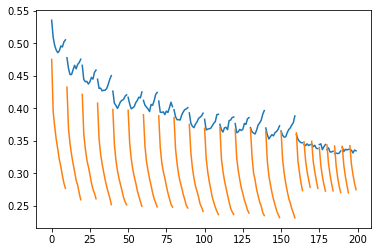

In [44]:
try:
    i0 = len(history.history['val_loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['loss'])
except:
    i0 = 0
for i in range(len(historys.keys())):
    vMOC = historys[i].history['val_loss']
    t = np.arange(len(vMOC))+i0
    plt.plot(t,vMOC,'C0')
    plt.plot(t,historys[i].history['loss'],'C1')
    
    i0 = t[-1]+1

In [31]:
model.save_weights("/mnt/data/synthetic/deepsofi_v2_1_t_"+str(i).zfill(3)+".h5")


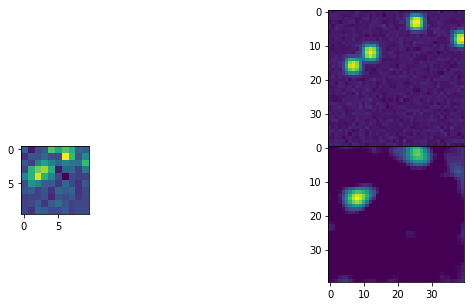

In [49]:
i = randint(100)
Ft, Ot4 = Xdev[i,:],Ydev[i,:]
pOt4 = model.predict(Ft.reshape(1,Ft.shape[0],Ft.shape[1],Ft.shape[2],1))
fig = plt.figure(figsize=(14,5))
gs = mpl.gridspec.GridSpec(8, 16 , wspace=0., hspace=0.) # 2x3 grid
Ft = np.squeeze(Ft)
pOt4 = np.squeeze(pOt4)

ax0 = fig.add_subplot(gs[4:6,4:6]) # first full col
ax1 = fig.add_subplot(gs[:4,8:]) # first row, second col
ax2 = fig.add_subplot(gs[4:,8:])
ax0.imshow(Ft.mean(axis=-1))
ax1.imshow(Ot4+np.random.randn(40,40)*.02)
ax2.imshow(pOt4)

In [29]:
pOt4.shape

(1, 40, 40)